This code takes images and OAR segmentation masks from the various image types (2-minute, ground-truth 6-minute, synthetic 6-minute) and performs various analyses relevant for the manuscript. Specifically, the code generates plots that are used in to replicate Figure 3 of the manuscript and associated results. 

There are 2 main parts of the analysis.

1. Direct comparisons of synthetic vs. ground-truth images - Directly measuring overlap between segmentations generated on ground-truth 6-minute scan vs. segmentations generated on synthetic 6-minute scan.
2. Comparisons relative to 2-minute image - Measuring overlap between segmentation generated on image of interest (ground-truth 6-minute scan OR synthetic 6-minute scan) vs. segmentation generated on 2-minute scan. We do this since the autosegmentation model was intially developed for 2-minute scans. More info in the paper. 

Last updated: October, 6, 2022 by Kareem Wahid. 

## Dependencies

In [1]:
import pandas as pd
import os
import shutil
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("whitegrid", {'axes.grid' : False})

from surface_distance import compute_surface_distances, compute_surface_dice_at_tolerance, compute_dice_coefficient, compute_average_surface_distance, compute_robust_hausdorff

In [2]:
%config InlineBackend.figure_format='retina' # for high quality plot

## Main Code - Direct comparisons of synthetic vs. ground-truth images

In [4]:
%%time

df_metrics_direct = pd.DataFrame(columns=['MRN', 'ROI', 'DSC', 'SDSC', 'HD95', 'ASD']) # make dataframe
counter = -1  

ROI_list = ['parotid_l', 'parotid_r', 'bone_mandible', 'glnd_submand_l', 'glnd_submand_r', 'spinalcord', 'brainstem'] # just two parotids for now 

nifti_path = "nifti_output"

MRNs = os.listdir(nifti_path)

for roi in ROI_list:
    print(roi)

    for MRN in MRNs:

        print(MRN)

        MRN_path = os.path.join(nifti_path, MRN)

        gt_file_path = os.path.join(MRN_path, '6min_synthetic_N4_' + roi +'.nii.gz') # now for comparing synthetic 

        mask_file_path = os.path.join(MRN_path, '6min_real_' + roi +'.nii.gz') 

        #print(gt_file_path)
        #print(mask_file_path)

        if os.path.exists(gt_file_path) and os.path.exists(mask_file_path):

            gt_file = sitk.ReadImage(gt_file_path)
            mask_file = sitk.ReadImage(mask_file_path)

            spacing_mm = mask_file.GetSpacing() # need spacing to calcualte distance

            # the transform shouldn't do anything for synthetic since same as 2min, double check that later..
            nifti_image_pred_transform = sitk.Resample(gt_file, mask_file, sitk.Transform(), sitk.sitkNearestNeighbor, 0, gt_file.GetPixelID()) # https://discourse.itk.org/t/resample-to-same-origin-spacing-and-size-as-another-image/3031
            image_pred_transform = sitk.GetArrayFromImage(nifti_image_pred_transform) # ground truth mask resampled

            mask_pred = sitk.GetArrayFromImage(mask_file) # prediction mask

            mask_gt_bool = image_pred_transform.astype(bool) # need to convert to bool format to work    
            mask_pred_bool = mask_pred.astype(bool)  

            DSC = compute_dice_coefficient(image_pred_transform, mask_pred)

            surface_distances = compute_surface_distances(mask_gt_bool, mask_pred_bool, spacing_mm) # need this for all calculations

            SDSC = compute_surface_dice_at_tolerance(surface_distances, 2.5)

            HD95 = compute_robust_hausdorff(surface_distances, 95)

            ASD_truth = compute_average_surface_distance(surface_distances)[0] #  A tuple with two float values: 1. the average distance (in mm) from the ground truth surface to thepredicted surface, 2. the average distance from the predicted surface to the ground truth surface.
            ASD_pred = compute_average_surface_distance(surface_distances)[1]
            ASD = (ASD_truth + ASD_pred)/2

            counter +=1
            df_metrics_direct.loc[counter] = [MRN, roi, DSC, SDSC, HD95, ASD]

parotid_l
1150757675
1389864037
1401204987
1787293395
1945523813
1945979999
2000997454
2212371295
2278732249
2326610791
2589026023
3244262639
3337525186
3376193121
3376859407
3641355426
6013720195
7462859887
parotid_r
1150757675
1389864037
1401204987
1787293395
1945523813
1945979999
2000997454
2212371295
2278732249
2326610791
2589026023
3244262639
3337525186
3376193121
3376859407
3641355426
6013720195
7462859887
bone_mandible
1150757675
1389864037
1401204987
1787293395
1945523813
1945979999
2000997454
2212371295
2278732249
2326610791
2589026023
3244262639
3337525186
3376193121
3376859407
3641355426
6013720195
7462859887
glnd_submand_l
1150757675
1389864037
1401204987
1787293395
1945523813
1945979999
2000997454
2212371295
2278732249
2326610791
2589026023
3244262639
3337525186
3376193121
3376859407
3641355426
6013720195
7462859887
glnd_submand_r
1150757675
1389864037
1401204987
1787293395
1945523813
1945979999
2000997454
2212371295
2278732249
2326610791
2589026023
3244262639
3337525186
3

## Plots - Direct comparisons of synthetic vs. ground-truth images¶

In [5]:
df_metrics_direct

,MRN,ROI,DSC,SDSC,HD95,ASD
0,1150757675,parotid_l,0.906003,0.964888,2.301832,0.856941
1,1389864037,parotid_l,0.698081,0.644389,12.816903,2.761968
2,1401204987,parotid_l,0.717108,0.751190,18.293784,2.475315
3,1787293395,parotid_l,0.857892,0.891778,3.559641,1.138265
4,1945523813,parotid_l,0.770081,0.717134,25.038096,3.081976
...,...,...,...,...,...,...
120,3376193121,brainstem,0.946309,1.000000,1.291680,0.321537
121,3376859407,brainstem,0.910823,0.963709,2.309973,0.562497
122,3641355426,brainstem,0.847054,0.885152,4.669304,0.948480
123,6013720195,brainstem,0.831785,0.946984,4.037454,0.978747


In [27]:
# still will need to boxplot it anyways so thats fine 

df_metrics_direct_reduced = df_metrics_direct[(df_metrics_direct['ROI'] == "parotid_l") |(df_metrics_direct['ROI'] == "parotid_r") | (df_metrics_direct['ROI'] == "bone_mandible")]

In [28]:
df_metrics_direct_reduced

,MRN,ROI,DSC,SDSC,HD95,ASD
0,1150757675,parotid_l,0.906003,0.964888,2.301832,0.856941
1,1389864037,parotid_l,0.698081,0.644389,12.816903,2.761968
2,1401204987,parotid_l,0.717108,0.751190,18.293784,2.475315
3,1787293395,parotid_l,0.857892,0.891778,3.559641,1.138265
4,1945523813,parotid_l,0.770081,0.717134,25.038096,3.081976
5,1945979999,parotid_l,0.906432,0.940185,3.623463,0.881147
6,2000997454,parotid_l,0.816237,0.863922,4.269079,1.342811
7,2212371295,parotid_l,0.868066,0.868667,3.385417,1.304749
8,2278732249,parotid_l,0.907219,0.926930,3.452461,0.900710
9,2326610791,parotid_l,0.887949,0.943721,2.677637,1.089183


In [29]:
# remove the bad right parotid patient
df_metrics_direct_reduced = df_metrics_direct_reduced[(df_metrics_direct_reduced["MRN"] != "7462859887") | (df_metrics_direct_reduced["ROI"] != "parotid_r")]

In [30]:
df_metrics_direct_reduced

,MRN,ROI,DSC,SDSC,HD95,ASD
0,1150757675,parotid_l,0.906003,0.964888,2.301832,0.856941
1,1389864037,parotid_l,0.698081,0.644389,12.816903,2.761968
2,1401204987,parotid_l,0.717108,0.751190,18.293784,2.475315
3,1787293395,parotid_l,0.857892,0.891778,3.559641,1.138265
4,1945523813,parotid_l,0.770081,0.717134,25.038096,3.081976
5,1945979999,parotid_l,0.906432,0.940185,3.623463,0.881147
6,2000997454,parotid_l,0.816237,0.863922,4.269079,1.342811
7,2212371295,parotid_l,0.868066,0.868667,3.385417,1.304749
8,2278732249,parotid_l,0.907219,0.926930,3.452461,0.900710
9,2326610791,parotid_l,0.887949,0.943721,2.677637,1.089183


[Text(0, 0.5, 'DSC (GT vs. synthetic 6-minute)')]

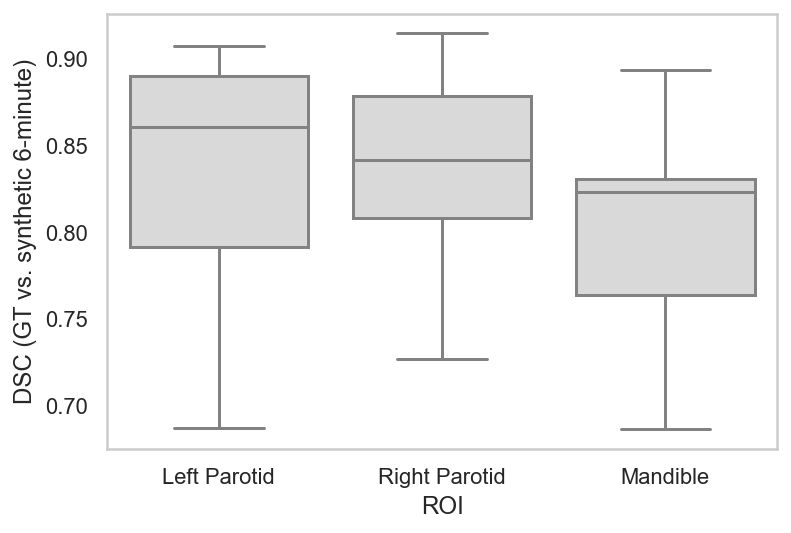

In [35]:
palette_tab10 = sns.color_palette("Set3") # https://stackoverflow.com/questions/66948177/how-can-i-select-a-specific-color-from-matplotlib-colormaps
palette = sns.color_palette([palette_tab10[8], palette_tab10[8], palette_tab10[8]])

ax = sns.boxplot(x="ROI", y="DSC", 
                 data=df_metrics_direct_reduced, palette=palette)

labels = ['Left Parotid', 'Right Parotid', 'Mandible']
ax.set_xticklabels(labels)
ax.set(ylabel='DSC (GT vs. synthetic 6-minute)')

#plt.legend(title='Image', labels=['Ground-truth', 'Synthetic'])

#plt.show(ax)

[Text(0, 0.5, 'ASD (GT vs. synthetic 6-minute, mm)')]

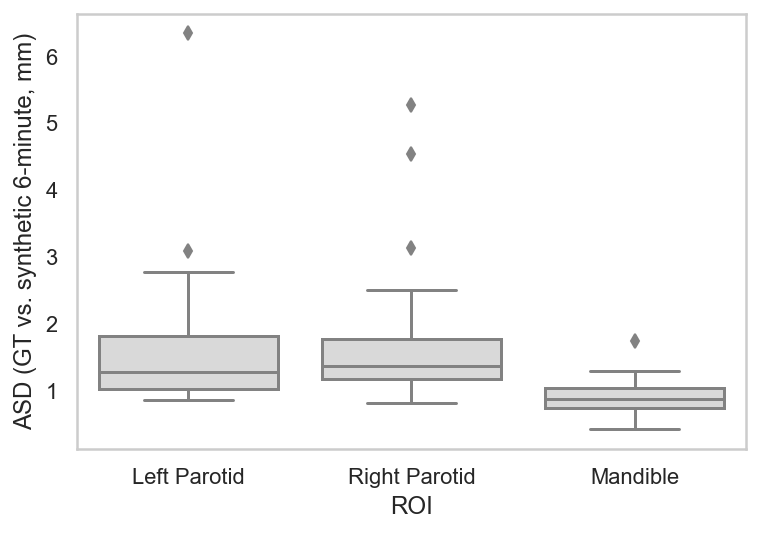

In [36]:
palette_tab10 = sns.color_palette("Set3") # https://stackoverflow.com/questions/66948177/how-can-i-select-a-specific-color-from-matplotlib-colormaps
palette = sns.color_palette([palette_tab10[8], palette_tab10[8], palette_tab10[8]])

ax = sns.boxplot(x="ROI", y="ASD",
                 data=df_metrics_direct_reduced, palette=palette)

labels = ['Left Parotid', 'Right Parotid', 'Mandible']
ax.set_xticklabels(labels)

ax.set(ylabel='ASD (GT vs. synthetic 6-minute, mm)')

In [33]:
df_metrics_direct_reduced.groupby(['ROI']).median()

,DSC,SDSC,HD95,ASD
ROI,,,,
bone_mandible,0.823081,0.938997,3.335855,0.870337
parotid_l,0.860417,0.871569,4.471197,1.273131
parotid_r,0.841479,0.875952,6.155107,1.360564


In [34]:
df_metrics_direct_reduced.groupby(['ROI']).quantile(0.75) - df_metrics_direct_reduced.groupby(['ROI']).quantile(0.25)

C:\Users\kawahid\AppData\Local\Temp/ipykernel_18228/638889624.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_metrics_direct_reduced.groupby(['ROI']).quantile(0.75) - df_metrics_direct_reduced.groupby(['ROI']).quantile(0.25)


,DSC,SDSC,HD95,ASD
ROI,,,,
bone_mandible,0.067155,0.040909,1.242196,0.290554
parotid_l,0.098706,0.151392,5.367579,0.792200
parotid_r,0.070470,0.090017,6.979825,0.605971


In [19]:
# remove cases with surgical removal of ROI
df_metrics_direct_reduced = df_metrics_direct[(df_metrics_direct["MRN"] != "2326610791") | (df_metrics_direct["ROI"] != "glnd_submand_l")]
df_metrics_direct_reduced = df_metrics_direct_reduced[(df_metrics_direct_reduced["MRN"] != "7462859887") | (df_metrics_direct_reduced["ROI"] != "glnd_submand_r")]
df_metrics_direct_reduced = df_metrics_direct_reduced[(df_metrics_direct_reduced["MRN"] != "7462859887") | (df_metrics_direct_reduced["ROI"] != "parotid_r")]

In [20]:
df_metrics_direct_reduced

,MRN,ROI,DSC,SDSC,HD95,ASD
0,1150757675,parotid_l,0.906003,0.964888,2.301832,0.856941
1,1389864037,parotid_l,0.698081,0.644389,12.816903,2.761968
2,1401204987,parotid_l,0.717108,0.751190,18.293784,2.475315
3,1787293395,parotid_l,0.857892,0.891778,3.559641,1.138265
4,1945523813,parotid_l,0.770081,0.717134,25.038096,3.081976
...,...,...,...,...,...,...
120,3376193121,brainstem,0.946309,1.000000,1.291680,0.321537
121,3376859407,brainstem,0.910823,0.963709,2.309973,0.562497
122,3641355426,brainstem,0.847054,0.885152,4.669304,0.948480
123,6013720195,brainstem,0.831785,0.946984,4.037454,0.978747


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'parotid_l'),
  Text(1, 0, 'parotid_r'),
  Text(2, 0, 'bone_mandible'),
  Text(3, 0, 'glnd_submand_l'),
  Text(4, 0, 'glnd_submand_r'),
  Text(5, 0, 'spinalcord'),
  Text(6, 0, 'brainstem')])

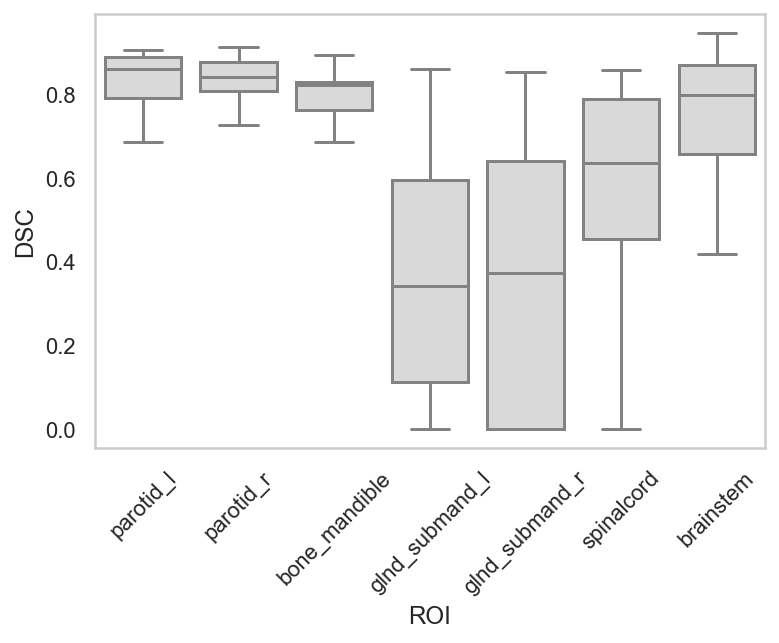

In [24]:
ax = sns.boxplot(x="ROI", y="DSC",
                 data=df_metrics_direct_reduced, palette=palette)

plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'parotid_l'),
  Text(1, 0, 'parotid_r'),
  Text(2, 0, 'bone_mandible'),
  Text(3, 0, 'glnd_submand_l'),
  Text(4, 0, 'glnd_submand_r'),
  Text(5, 0, 'spinalcord'),
  Text(6, 0, 'brainstem')])

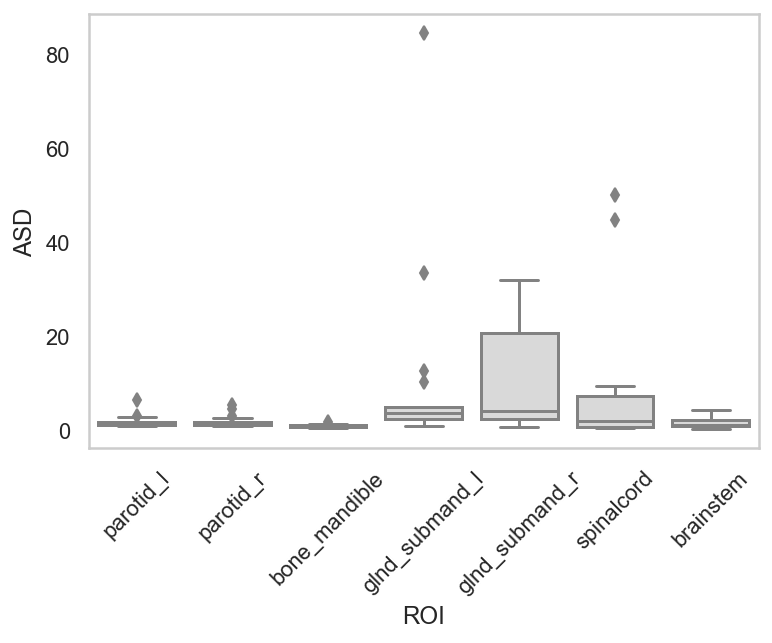

In [25]:
ax = sns.boxplot(x="ROI", y="ASD", 
                 data=df_metrics_direct_reduced, palette=palette)

plt.xticks(rotation=45)

## Main Code - Comparisons relative to 2-minute image

In [89]:
%%time

df_metrics = pd.DataFrame(columns=['MRN', 'Image', 'ROI', 'DSC', 'SDSC', 'HD95', 'ASD']) # make dataframe
counter = -1  

ROI_list = ['parotid_l', 'parotid_r', 'bone_mandible', 'glnd_submand_l', 'glnd_submand_r', 'spinalcord', 'brainstem'] # just two parotids for now 

nifti_path = "nifti_output"

image_list = ['original', '6min_synthetic', '6min_synthetic_N4']

MRNs = os.listdir(nifti_path)

for image in image_list:
    print(image)

    for roi in ROI_list:
        #print(roi)

        for MRN in MRNs:

            #print(MRN)

            MRN_path = os.path.join(nifti_path, MRN)

            gt_file_path = os.path.join(MRN_path, '2min_real_' + roi +'.nii.gz') # original for test, comparing two minute to six min real

            if image == "original":
                mask_file_path = os.path.join(MRN_path, '6min_real_' + roi +'.nii.gz')
            elif image == "6min_synthetic":
                mask_file_path = os.path.join(MRN_path, '6min_synthetic_' + roi +'.nii.gz') # now for comparing synthetic 
            elif image == "6min_synthetic_N4":
                mask_file_path = os.path.join(MRN_path, '6min_synthetic_N4_' + roi +'.nii.gz') # now for comparing synthetic 

            #print(gt_file_path)
            #print(mask_file_path)

            if os.path.exists(gt_file_path) and os.path.exists(mask_file_path):

                gt_file = sitk.ReadImage(gt_file_path)
                mask_file = sitk.ReadImage(mask_file_path)

                spacing_mm = mask_file.GetSpacing() # need spacing to calcualte distance

                # the transform shouldn't do anything for synthetic since same as 2min, double check that later..
                nifti_image_pred_transform = sitk.Resample(gt_file, mask_file, sitk.Transform(), sitk.sitkNearestNeighbor, 0, gt_file.GetPixelID()) # https://discourse.itk.org/t/resample-to-same-origin-spacing-and-size-as-another-image/3031
                image_pred_transform = sitk.GetArrayFromImage(nifti_image_pred_transform) # ground truth mask resampled

                mask_pred = sitk.GetArrayFromImage(mask_file) # prediction mask

                mask_gt_bool = image_pred_transform.astype(bool) # need to convert to bool format to work    
                mask_pred_bool = mask_pred.astype(bool)  

                DSC = compute_dice_coefficient(image_pred_transform, mask_pred)

                surface_distances = compute_surface_distances(mask_gt_bool, mask_pred_bool, spacing_mm) # need this for all calculations

                SDSC = compute_surface_dice_at_tolerance(surface_distances, 2.5)

                HD95 = compute_robust_hausdorff(surface_distances, 95)

                ASD_truth = compute_average_surface_distance(surface_distances)[0] #  A tuple with two float values: 1. the average distance (in mm) from the ground truth surface to thepredicted surface, 2. the average distance from the predicted surface to the ground truth surface.
                ASD_pred = compute_average_surface_distance(surface_distances)[1]
                ASD = (ASD_truth + ASD_pred)/2

                counter +=1
                df_metrics.loc[counter] = [MRN, image, roi, DSC, SDSC, HD95, ASD]

original
6min_synthetic
6min_synthetic_N4
Wall time: 22min 2s


In [90]:
#df_metrics.to_csv('df_metrics.csv', index=False) # save

## Plots - Comparisons relative to 2-minute image

In [37]:
df_metrics = pd.read_csv('df_metrics.csv') # load if avaliable 
df_metrics['MRN'] = df_metrics['MRN'].astype(str)

In [38]:
df_metrics

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
0,1150757675,original,parotid_l,0.862139,0.838050,8.446987,1.446848
1,1389864037,original,parotid_l,0.725012,0.601542,29.355894,4.694456
2,1401204987,original,parotid_l,0.573981,0.494512,38.451352,7.500999
3,1787293395,original,parotid_l,0.848495,0.852962,5.416667,1.279805
4,1945523813,original,parotid_l,0.812656,0.811902,3.948040,1.461480
...,...,...,...,...,...,...,...
372,3376193121,6min_synthetic_N4,brainstem,0.957547,1.000000,1.178511,0.260720
373,3376859407,6min_synthetic_N4,brainstem,0.900105,0.923005,3.201561,0.708499
374,3641355426,6min_synthetic_N4,brainstem,0.817284,0.807173,7.717222,1.482624
375,6013720195,6min_synthetic_N4,brainstem,0.411840,0.494985,23.243270,5.325636


First we investigate only select ROIs (parotids, mandible).

In [39]:
# still will need to boxplot it anyways so thats fine 

df_metrics_reduced = df_metrics[(df_metrics['ROI'] == "parotid_l") |(df_metrics['ROI'] == "parotid_r") | (df_metrics['ROI'] == "bone_mandible")]
df_metrics_reduced_models = df_metrics_reduced[(df_metrics_reduced['Image'] == "original") | (df_metrics_reduced['Image'] == "6min_synthetic_N4")]

In [40]:
df_metrics_reduced_models

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
0,1150757675,original,parotid_l,0.862139,0.838050,8.446987,1.446848
1,1389864037,original,parotid_l,0.725012,0.601542,29.355894,4.694456
2,1401204987,original,parotid_l,0.573981,0.494512,38.451352,7.500999
3,1787293395,original,parotid_l,0.848495,0.852962,5.416667,1.279805
4,1945523813,original,parotid_l,0.812656,0.811902,3.948040,1.461480
...,...,...,...,...,...,...,...
300,3376193121,6min_synthetic_N4,bone_mandible,0.899587,0.977781,1.943650,0.468823
301,3376859407,6min_synthetic_N4,bone_mandible,0.717560,0.830591,6.792559,1.376101
302,3641355426,6min_synthetic_N4,bone_mandible,0.917117,0.996475,1.301708,0.326706
303,6013720195,6min_synthetic_N4,bone_mandible,0.861581,0.958620,2.499999,0.589575


In [41]:
# remove the bad right parotid patient
df_metrics_reduced_models = df_metrics_reduced_models[(df_metrics_reduced_models["MRN"] != "7462859887") | (df_metrics_reduced_models["ROI"] != "parotid_r")]

In [42]:
df_metrics_reduced_models

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
0,1150757675,original,parotid_l,0.862139,0.838050,8.446987,1.446848
1,1389864037,original,parotid_l,0.725012,0.601542,29.355894,4.694456
2,1401204987,original,parotid_l,0.573981,0.494512,38.451352,7.500999
3,1787293395,original,parotid_l,0.848495,0.852962,5.416667,1.279805
4,1945523813,original,parotid_l,0.812656,0.811902,3.948040,1.461480
...,...,...,...,...,...,...,...
300,3376193121,6min_synthetic_N4,bone_mandible,0.899587,0.977781,1.943650,0.468823
301,3376859407,6min_synthetic_N4,bone_mandible,0.717560,0.830591,6.792559,1.376101
302,3641355426,6min_synthetic_N4,bone_mandible,0.917117,0.996475,1.301708,0.326706
303,6013720195,6min_synthetic_N4,bone_mandible,0.861581,0.958620,2.499999,0.589575


In [43]:
df_metrics_reduced_models['Image'] = df_metrics_reduced_models['Image'].str.replace('original','Ground-truth')
df_metrics_reduced_models['Image'] = df_metrics_reduced_models['Image'].str.replace('6min_synthetic_N4','Synthetic')

C:\Users\kawahid\AppData\Local\Temp/ipykernel_18228/3219029557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_reduced_models['Image'] = df_metrics_reduced_models['Image'].str.replace('original','Ground-truth')
C:\Users\kawahid\AppData\Local\Temp/ipykernel_18228/3219029557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_reduced_models['Image'] = df_metrics_reduced_models['Image'].str.replace('6min_synthetic_N4','Synthetic')


[Text(0, 0.5, 'DSC (image vs. 2-minute)')]

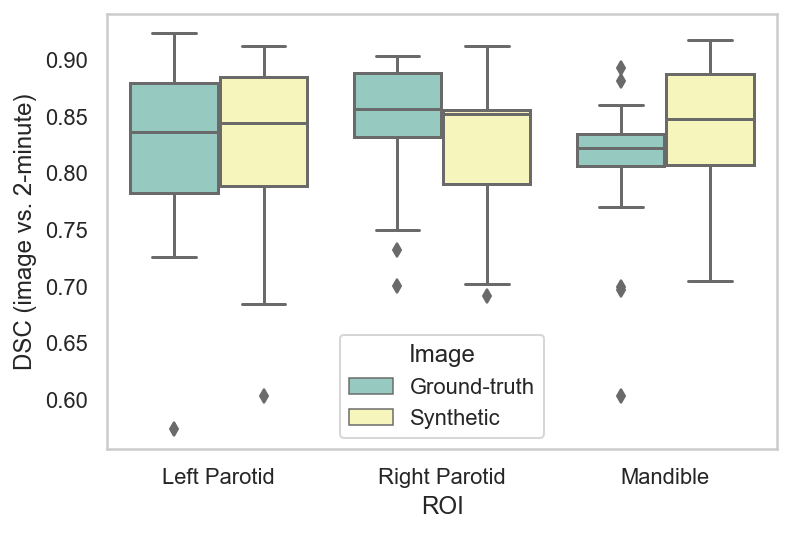

In [51]:
ax = sns.boxplot(x="ROI", y="DSC", hue="Image",
                 data=df_metrics_reduced_models, palette="Set3")

labels = ['Left Parotid', 'Right Parotid', 'Mandible']
ax.set_xticklabels(labels)

ax.set(ylabel='DSC (image vs. 2-minute)')

#plt.legend(title='Image', labels=['Ground-truth', 'Synthetic'])

#plt.show(ax)

[Text(0, 0.5, 'ASD (image vs. 2-minute, mm)')]

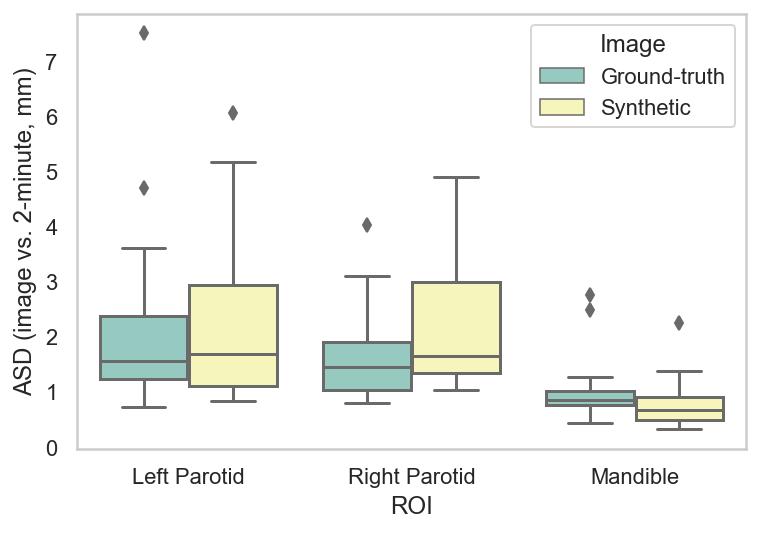

In [49]:
ax = sns.boxplot(x="ROI", y="ASD", hue="Image",
                 data=df_metrics_reduced_models, palette="Set3")

labels = ['Left Parotid', 'Right Parotid', 'Mandible']
ax.set_xticklabels(labels)

ax.set(ylabel='ASD (image vs. 2-minute, mm)')

In [46]:
df_metrics_reduced_models.groupby(['Image', 'ROI']).median()

DSC      SDSC      HD95       ASD
Image        ROI                                                  
Ground-truth bone_mandible  0.821544  0.928785  3.506051  0.855532
             parotid_l      0.835511  0.824976  6.548628  1.561592
             parotid_r      0.856132  0.843531  5.551690  1.445028
Synthetic    bone_mandible  0.847020  0.951691  3.199722  0.665745
             parotid_l      0.843972  0.798845  8.914298  1.688271
             parotid_r      0.851457  0.829192  6.148620  1.652819

In [47]:
df_metrics_reduced_models.groupby(['Image', 'ROI']).quantile(0.75) - df_metrics_reduced_models.groupby(['Image', 'ROI']).quantile(0.25)

C:\Users\kawahid\AppData\Local\Temp/ipykernel_18228/110811375.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_metrics_reduced_models.groupby(['Image', 'ROI']).quantile(0.75) - df_metrics_reduced_models.groupby(['Image', 'ROI']).quantile(0.25)


DSC      SDSC       HD95       ASD
Image        ROI                                                   
Ground-truth bone_mandible  0.028218  0.038803   1.696129  0.250550
             parotid_l      0.097265  0.199979   6.461649  1.144828
             parotid_r      0.055880  0.089803   8.333358  0.880561
Synthetic    bone_mandible  0.080342  0.060798   2.773949  0.408960
             parotid_l      0.096009  0.162498  16.824745  1.834071
             parotid_r      0.065301  0.125617  16.461837  1.655568

Now we investigate all the ROIs.

In [190]:
df_metrics_reduced_models = df_metrics[(df_metrics['Image'] == "original") | (df_metrics['Image'] == "6min_synthetic_N4")]

In [191]:
df_metrics_reduced_models

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
0,1150757675,original,parotid_l,0.862139,0.838050,8.446987,1.446848
1,1389864037,original,parotid_l,0.725012,0.601542,29.355894,4.694456
2,1401204987,original,parotid_l,0.573981,0.494512,38.451352,7.500999
3,1787293395,original,parotid_l,0.848495,0.852962,5.416667,1.279805
4,1945523813,original,parotid_l,0.812656,0.811902,3.948040,1.461480
...,...,...,...,...,...,...,...
372,3376193121,6min_synthetic_N4,brainstem,0.957547,1.000000,1.178511,0.260720
373,3376859407,6min_synthetic_N4,brainstem,0.900105,0.923005,3.201561,0.708499
374,3641355426,6min_synthetic_N4,brainstem,0.817284,0.807173,7.717222,1.482624
375,6013720195,6min_synthetic_N4,brainstem,0.411840,0.494985,23.243270,5.325636


In [193]:
# remove cases with surgical removal of ROI
df_metrics_reduced_models = df_metrics_reduced_models[(df_metrics_reduced_models["MRN"] != "2326610791") | (df_metrics_reduced_models["ROI"] != "glnd_submand_l")]
df_metrics_reduced_models = df_metrics_reduced_models[(df_metrics_reduced_models["MRN"] != "7462859887") | (df_metrics_reduced_models["ROI"] != "glnd_submand_r")]
df_metrics_reduced_models = df_metrics_reduced_models[(df_metrics_reduced_models["MRN"] != "7462859887") | (df_metrics_reduced_models["ROI"] != "parotid_r")]

In [194]:
df_metrics_reduced_models

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
0,1150757675,original,parotid_l,0.862139,0.838050,8.446987,1.446848
1,1389864037,original,parotid_l,0.725012,0.601542,29.355894,4.694456
2,1401204987,original,parotid_l,0.573981,0.494512,38.451352,7.500999
3,1787293395,original,parotid_l,0.848495,0.852962,5.416667,1.279805
4,1945523813,original,parotid_l,0.812656,0.811902,3.948040,1.461480
...,...,...,...,...,...,...,...
372,3376193121,6min_synthetic_N4,brainstem,0.957547,1.000000,1.178511,0.260720
373,3376859407,6min_synthetic_N4,brainstem,0.900105,0.923005,3.201561,0.708499
374,3641355426,6min_synthetic_N4,brainstem,0.817284,0.807173,7.717222,1.482624
375,6013720195,6min_synthetic_N4,brainstem,0.411840,0.494985,23.243270,5.325636


In [196]:
df_metrics_reduced_models[df_metrics_reduced_models["ROI"] == "bone_mandible"]

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
36,1150757675,original,bone_mandible,0.880612,0.990368,1.744639,0.503127
37,1389864037,original,bone_mandible,0.603070,0.760879,24.448028,2.762164
38,1401204987,original,bone_mandible,0.834657,0.952084,2.791686,0.744956
39,1787293395,original,bone_mandible,0.805412,0.921697,4.421275,0.852984
40,1945523813,original,bone_mandible,0.806031,0.961787,2.583374,0.852967
41,1945979999,original,bone_mandible,0.830961,0.966562,2.301832,0.776998
42,2000997454,original,bone_mandible,0.822491,0.921060,5.268973,1.018030
43,2212371295,original,bone_mandible,0.859708,0.984951,1.915081,0.685614
44,2278732249,original,bone_mandible,0.805825,0.940757,3.286294,0.760648
45,2326610791,original,bone_mandible,0.696648,0.859803,4.917803,1.267605


In [197]:
df_metrics_reduced_models['Image'] = df_metrics_reduced_models['Image'].str.replace('original','Ground-truth')
df_metrics_reduced_models['Image'] = df_metrics_reduced_models['Image'].str.replace('6min_synthetic_N4','Synthetic')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'parotid_l'),
  Text(1, 0, 'parotid_r'),
  Text(2, 0, 'bone_mandible'),
  Text(3, 0, 'glnd_submand_l'),
  Text(4, 0, 'glnd_submand_r'),
  Text(5, 0, 'spinalcord'),
  Text(6, 0, 'brainstem')])

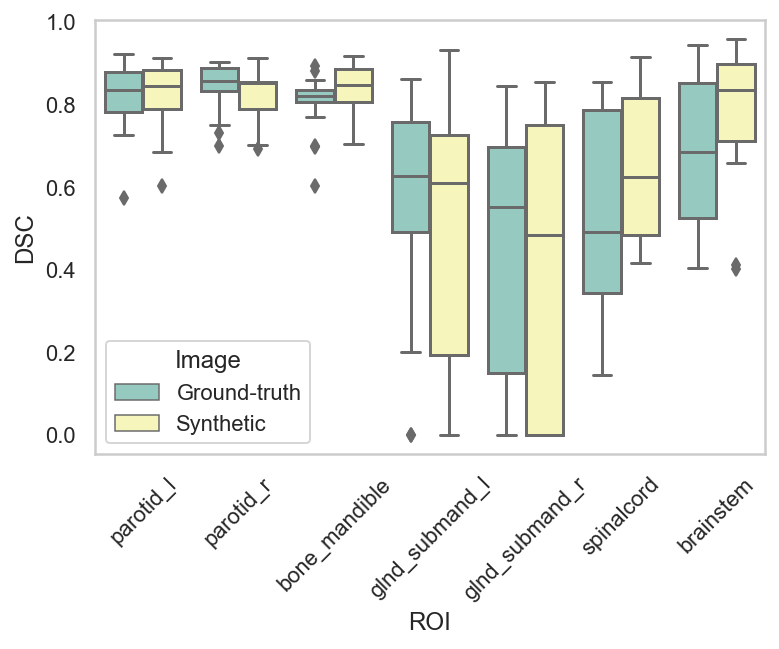

In [209]:
ax = sns.boxplot(x="ROI", y="DSC", hue="Image",
                 data=df_metrics_reduced_models, palette="Set3")

plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'parotid_l'),
  Text(1, 0, 'parotid_r'),
  Text(2, 0, 'bone_mandible'),
  Text(3, 0, 'glnd_submand_l'),
  Text(4, 0, 'glnd_submand_r'),
  Text(5, 0, 'spinalcord'),
  Text(6, 0, 'brainstem')])

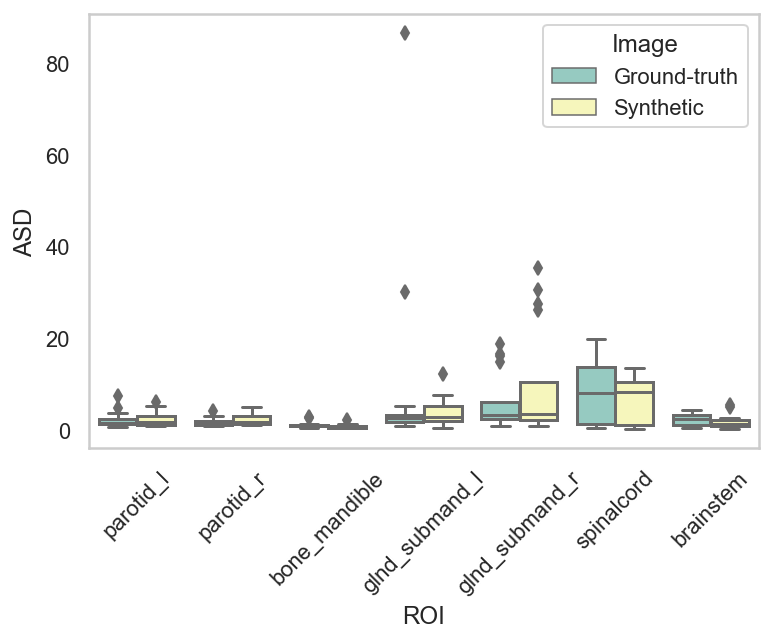

In [210]:
ax = sns.boxplot(x="ROI", y="ASD", hue="Image",
                 data=df_metrics_reduced_models, palette="Set3")

plt.xticks(rotation=45)

## Stats - Comparisons relative to 2-minute image

In [200]:
df_metrics_reduced_models.groupby(['Image', 'ROI']).describe()

DSC                                          \
                            count      mean       std       min       25%   
Image        ROI                                                            
Ground-truth bone_mandible   18.0  0.801001  0.070597  0.603070  0.805515   
             brainstem       18.0  0.687063  0.187239  0.403606  0.525236   
             glnd_submand_l  17.0  0.553077  0.263116  0.000000  0.489986   
             glnd_submand_r  17.0  0.433976  0.311316  0.000000  0.149926   
             parotid_l       18.0  0.817685  0.082637  0.573981  0.781581   
             parotid_r       17.0  0.842619  0.061012  0.700213  0.831541   
             spinalcord      18.0  0.516090  0.241704  0.143701  0.343776   
Synthetic    bone_mandible   18.0  0.834669  0.067604  0.703844  0.806180   
             brainstem       18.0  0.784282  0.164977  0.402302  0.710412   
             glnd_submand_l  17.0  0.510657  0.298783  0.000000  0.193505   
             glnd_submand_r  17.0  0.428126  0.336617  0.000000  0.000000   
             parotid_l       18.0  0.820844  0.081204  0.602467  0.788309   
             parotid_r       17.0  0.825424  0.062110  0.691346  0.790057   
             spinalcord      18.0  0.651329  0.178144  0.415144  0.482568   

                                                           SDSC            \
                                  50%       75%       max count      mean   
Image        ROI                                                            
Ground-truth bone_mandible   0.821544  0.833733  0.892228  18.0  0.922265   
             brainstem       0.683825  0.852293  0.942751  18.0  0.706140   
             glnd_submand_l  0.626554  0.756276  0.862744  17.0  0.582171   
             glnd_submand_r  0.552163  0.695937  0.845569  17.0  0.445968   
             parotid_l       0.835511  0.878846  0.922670  18.0  0.776321   
             parotid_r       0.856132  0.887421  0.902718  17.0  0.834886   
             spinalcord      0.491031  0.785531  0.853968  18.0  0.646566   
Synthetic    bone_mandible   0.847020  0.886523  0.917117  18.0  0.933359   
             brainstem       0.834119  0.898662  0.957547  18.0  0.804547   
             glnd_submand_l  0.609415  0.725892  0.931233  17.0  0.547124   
             glnd_submand_r  0.484202  0.749096  0.854404  17.0  0.454799   
             parotid_l       0.843972  0.884317  0.911667  18.0  0.783282   
             parotid_r       0.851457  0.855358  0.911306  17.0  0.790504   
             spinalcord      0.625135  0.815221  0.915661  18.0  0.774337   

                             ...       HD95              ASD            \
                             ...        75%        max count      mean   
Image        ROI             ...                                         
Ground-truth bone_mandible   ...   4.331581  24.448028  18.0  1.034184   
             brainstem       ...  12.882327  16.401479  18.0  2.192312   
             glnd_submand_l  ...  14.118264  99.026127  17.0  8.977502   
             glnd_submand_r  ...  19.750255  33.178155  17.0  6.221684   
             parotid_l       ...  10.533128  38.451352  18.0  2.180425   
             parotid_r       ...  11.718774  24.634616  17.0  1.655200   
             spinalcord      ...  71.929005  92.428140  18.0  8.030914   
Synthetic    bone_mandible   ...   4.863205  21.930443  18.0  0.796532   
             brainstem       ...   9.530440  23.243270  18.0  1.689493   
             glnd_submand_l  ...  16.634129  27.775878  17.0  3.921706   
             glnd_submand_r  ...  26.744676  52.493369  17.0  9.652632   
             parotid_l       ...  21.709328  34.332513  18.0  2.226296   
             parotid_r       ...  21.826327  29.584615  17.0  2.145417   
             spinalcord      ...  76.625562  87.918647  18.0  6.759010   

                                                                      \
                                   std       min       25%       50%   
Image  

In [201]:
df_metrics_reduced_models[df_metrics_reduced_models["ROI"] == "glnd_submand_r"]

,MRN,Image,ROI,DSC,SDSC,HD95,ASD
72,1150757675,Ground-truth,glnd_submand_r,0.742884,0.787722,14.953494,2.314474
73,1389864037,Ground-truth,glnd_submand_r,0.568190,0.576488,6.599991,2.427374
74,1401204987,Ground-truth,glnd_submand_r,0.000000,0.000000,26.343578,14.832300
75,1787293395,Ground-truth,glnd_submand_r,0.801426,0.861310,3.875041,1.126438
76,1945523813,Ground-truth,glnd_submand_r,0.161591,0.226161,19.750255,6.102019
77,1945979999,Ground-truth,glnd_submand_r,0.695937,0.685544,6.017446,1.900875
78,2000997454,Ground-truth,glnd_submand_r,0.000000,0.000000,28.380370,18.838852
79,2212371295,Ground-truth,glnd_submand_r,0.845569,0.911173,3.646205,0.935966
80,2278732249,Ground-truth,glnd_submand_r,0.570283,0.523926,14.905668,3.343020
81,2326610791,Ground-truth,glnd_submand_r,0.493322,0.354688,10.540102,4.006449


In [202]:
from statsmodels.stats.weightstats import ttost_paired

In [203]:
l_parotid_IQR_DSC = 0.86-0.78
r_parotid_IQR_DSC = 0.86-0.79
mandible_IQR_DSC = 0.75-0.65
r_submand_IQR_DSC = 0.82-0.71
l_submand_IQR_DSC = 0.83-0.71
brainstem_IQR_DSC = 0.89-0.82
spinalcord_IQR_DSC = 0.88-0.78

l_parotid_IQR_ASD = 1.75-.70
r_parotid_IQR_ASD = 1.7-.70
mandible_IQR_ASD = 1.75-.65
r_submand_IQR_ASD = 2.00-1.00
l_submand_IQR_ASD = 2.20-1.00
brainstem_IQR_ASD = 1.40-1.00
spinalcord_IQR_ASD = 0.70-0.50

In [204]:
IQR_dict = {"parotid_l": {"DSC": l_parotid_IQR_DSC, "ASD": l_parotid_IQR_ASD},
            "parotid_r": {"DSC": r_parotid_IQR_DSC, "ASD": r_parotid_IQR_ASD},
            "bone_mandible": {"DSC": mandible_IQR_DSC, "ASD": mandible_IQR_ASD},
            "glnd_submand_l": {"DSC": l_submand_IQR_DSC, "ASD": l_submand_IQR_ASD},
            "glnd_submand_r": {"DSC": r_submand_IQR_DSC, "ASD": r_submand_IQR_ASD},
            "spinalcord": {"DSC": spinalcord_IQR_DSC, "ASD": spinalcord_IQR_ASD},
            "brainstem": {"DSC": brainstem_IQR_DSC, "ASD": brainstem_IQR_ASD},
           }

In [205]:
ROI_list = ['parotid_l', 'parotid_r', 'bone_mandible', 'glnd_submand_l', 'glnd_submand_r', 'spinalcord', 'brainstem'] # just two parotids for now 

metric_list = ["DSC", "ASD"]

for ROI in ROI_list:
    print(ROI)
    for metric in metric_list:
        print(metric)
        thresh = IQR_dict[ROI][metric]
        print(thresh)
        
        original_list = df_metrics_reduced_models[(df_metrics_reduced_models["Image"]=="Ground-truth") & (df_metrics_reduced_models["ROI"]==ROI)][metric]
        synthetic_list = df_metrics_reduced_models[(df_metrics_reduced_models["Image"]=="Synthetic") & (df_metrics_reduced_models["ROI"]==ROI)][metric]
        
        print(ttost_paired(original_list.values, synthetic_list.values, low= -thresh, upp= thresh))

parotid_l
DSC
0.07999999999999996
(1.0809588216201067e-07, (8.311359643312406, 1.0809588216201067e-07, 17.0), (-8.994721145706718, 3.572738647166504e-08, 17.0))
ASD
1.05
(4.991826224231672e-05, (5.044548690819122, 4.991826224231672e-05, 17.0), (-5.505444805868718, 1.9303692379410785e-05, 17.0))
parotid_r
DSC
0.06999999999999995
(0.0010029639510914198, (6.084636641745261, 7.895887956563565e-06, 16.0), (-3.684753503236893, 0.0010029639510914198, 16.0))
ASD
1.0
(0.048076473269114024, (1.767817371750032, 0.048076473269114024, 16.0), (-5.1677561562147, 4.672687931097136e-05, 16.0))
bone_mandible
DSC
0.09999999999999998
(3.48208504645347e-05, (5.217871523969824, 3.48208504645347e-05, 17.0), (-10.514705847157918, 3.6912863735609275e-09, 17.0))
ASD
1.1
(1.577520679958624e-07, (12.542614875524151, 2.5501693926919216e-10, 17.0), (-8.085890963239322, 1.577520679958624e-07, 17.0))
glnd_submand_l
DSC
0.12
(0.23660318071647884, (1.5379891369669045, 0.07179565654641379, 16.0), (-0.7346111217810359, 0